In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.graph_objects as go
url = "./data_labels_mainData.csv"
lm = pd.read_csv(url, header=0, sep=",")
url = "./data_labels_extraData.csv"
le = pd.read_csv(url, header = 0, sep = ",")

#c/download/mlass2
#im guessing all images are 27x27

"""#might have to run the following lines if wanting to use gpu
export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"
CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib
export PATH="${PATH}:/usr/local/nvidia/bin:/usr/local/cuda/bin"

symbiotic links
"""
"""
cd /usr/lib/wsl/lib/
sudo cp libcuda.so.1 libcuda.so.1.backup
sudo cp libcuda.so libcuda.so.backup
sudo rm libcuda.so.1
sudo rm libcuda.so
sudo ln -s libcuda.so.1.1 libcuda.so.1
sudo ln -s libcuda.so.1.1 libcuda.so
sudo ldconfig
"""

'\ncd /usr/lib/wsl/lib/\nsudo cp libcuda.so.1 libcuda.so.1.backup\nsudo cp libcuda.so libcuda.so.backup\nsudo rm libcuda.so.1\nsudo rm libcuda.so\nsudo ln -s libcuda.so.1.1 libcuda.so.1\nsudo ln -s libcuda.so.1.1 libcuda.so\nsudo ldconfig\n'

In [55]:
lm.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [56]:
lm.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


In [57]:
lm.value_counts()

InstanceID  patientID  ImageName  cellTypeName  cellType  isCancerous
1           36         1.png      fibroblast    0         0              1
13760       54         13760.png  others        3         0              1
13753       54         13753.png  others        3         0              1
13754       54         13754.png  others        3         0              1
13755       54         13755.png  others        3         0              1
                                                                        ..
5480        50         5480.png   fibroblast    0         0              1
5481        50         5481.png   fibroblast    0         0              1
5482        50         5482.png   fibroblast    0         0              1
5483        50         5483.png   fibroblast    0         0              1
22444       27         22444.png  others        3         0              1
Length: 9896, dtype: int64

In [58]:
print(lm.groupby("cellTypeName").sum())

              InstanceID  patientID  cellType  isCancerous
cellTypeName                                              
epithelial      27445916     121296      8158         4079
fibroblast      24541213      55725         0            0
inflammatory    31935645      69164      2543            0
others          16955864      48340      4158            0


/tmp/ipykernel_5395/2613561896.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [59]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(lm, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(lm, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 7422, Val Data: 2474, Test Data: 1980


In [60]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.12.0'

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 32 by 32 pixels) to a one-dimensional array (of 32 * 32 * 3 = 3072 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected (MLP), neural layers. The first Dense layer has 256 nodes (or neurons). The second (and last) layer returns a logits array with length of 4. Each node contains a score that indicates the current image belongs to one of the 4 classes.

We can use `model.summary()` to print the model that was created.

Building the neural network requires configuring the layers of the model, then compiling the model and finally training the model.

### Set up the layers
The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most neural networks consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

A layer in the MLP is represented by `tf.keras.layers.Dense`. First lets define the dimensions of our neural network.

There are three ways to build a model in tensorflow: 
 - Functional API
 - Sub-classing
 - Sequential API

We will use the `Sequential` API to build models as it is the simplest.


### Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- **Loss function**: This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: This is how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [62]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7422 validated image filenames belonging to 4 classes.
Found 2474 validated image filenames belonging to 4 classes.


In [64]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

Now you know how to setup a neural network and train it in tensorflow.

### Incremental changes
Next step is doing the incremental updates to improve the performance. Observe the loss curves and act accordingly. Some options are.

**If the model is under fitting:** 
1. Increase the number of neurones in the hidden layer 
2. Increase the number of hidden layers

**If the model is over fitting:**
1. Add regulatization: Lasso/Ridge penalty
2. Add dropout
3. Reduce number of neurones in each layer or number of layers.

Some of the steps are done in the LectureQandA code for week 9 module - neural networks. You can get the basic syntax from there and implement accordingly.


> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Tune the neural network model to get the best performance possible. </font>**  

In [65]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [66]:
label_names = {'fibroplast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

In [67]:
#idk

In [68]:
# Define the number of output classes for each task
CELL_TYPE_CLASSES = 4
CANCEROUS_CLASSES = 2

# Define the model architecture
reg_lambda = 0.001

cellTypeModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CELL_TYPE_CLASSES),
])


In [69]:
cellTypeModel.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [70]:
cellTypeModel_VGG_1 = cellTypeModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/tmp/ipykernel_5395/240156875.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

2023-05-10 18:48:01.476481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-10 18:48:06.515488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


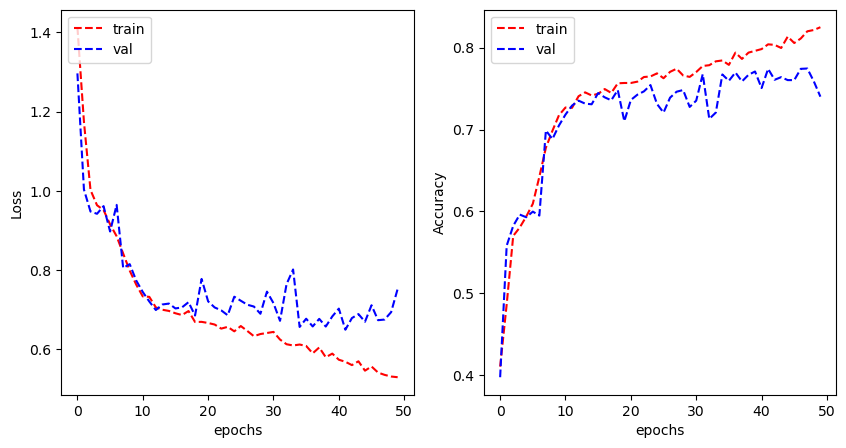

In [71]:
plot_learning_curve(cellTypeModel_VGG_1.history['loss'], cellTypeModel_VGG_1.history['val_loss'], 
                    cellTypeModel_VGG_1.history['categorical_accuracy'], cellTypeModel_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [72]:
cellTypeModel.evaluate(test_generator)

  28/1980 [..............................] - ETA: 11s - loss: 0.6918 - categorical_accuracy: 0.7500

2023-05-10 18:50:44.004624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 11s 6ms/step - loss: 0.7515 - categorical_accuracy: 0.7429


[0.7514662146568298, 0.7429292798042297]

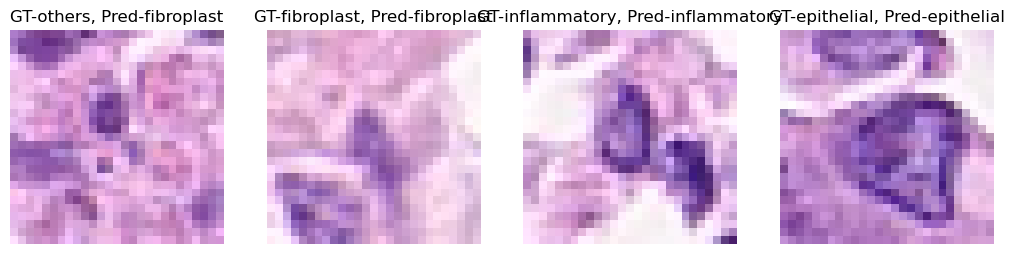

In [73]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = cellTypeModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [74]:
pseudoData = ImageDataGenerator(rescale=1./255, data_format='channels_last')
pseudoGen = pseudoData.flow_from_dataframe(
        dataframe=le,
        directory='./patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)

Found 10384 validated image filenames.


In [75]:
predictions = cellTypeModel.predict(pseudoGen)

   53/10384 [..............................] - ETA: 20s 

2023-05-10 18:50:56.126091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10384/10384 [==============================] - 20s 2ms/step


In [76]:
# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Add the predicted labels to the second dataframe
le['cellType'] = predicted_labels

In [105]:
le.head()

,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,0
1,12682,61,12682.png,0,2
2,12683,61,12683.png,0,2
3,12684,61,12684.png,0,1
4,12685,61,12685.png,0,1


In [77]:

train_dataHD, test_dataHD = train_test_split(le, test_size=0.2, random_state=42)
train_dataHD, val_dataHD = train_test_split(le, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_dataHD.shape[0], val_dataHD.shape[0], test_dataHD.shape[0]))

train_datagenHD = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagenHD = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagenHD.flow_from_dataframe(
        dataframe=train_dataHD,
        directory='./patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)

validation_generator = val_datagenHD.flow_from_dataframe(
        dataframe=val_dataHD,
        directory='./patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)

Train data : 7788, Val Data: 2596, Test Data: 2077
Found 7788 validated image filenames.
Found 2596 validated image filenames.


""MIGHT HAVE TO PERFORM DATA AGUMENTATION OR 
We can use any of the above techniques or a combination:
- Weight regularisation
- Dropout
- Removing layers or reducing number of kernels (making the model simple)
- Data Augmentation
- Gathering more data
- etc


PRBOS MAKE THE CANCER THING BINARY

In [78]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [79]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 7422 validated image filenames belonging to 2 classes.
Found 2474 validated image filenames belonging to 2 classes.


In [80]:
batch_x, batch_y = next(train_generator)
print(batch_x.shape)  # (batch_size, 27, 27, 3)
print(batch_y.shape)  # (batch_size, CELL_TYPE_CLASSES)


(32, 27, 27, 3)
(32,)


In [81]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 1980 validated image filenames belonging to 2 classes.


In [82]:
CANCEROUS_CLASSES = 1

# Define the model architecture
reg_lambda = 0.001

isCancerModel = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(CANCEROUS_CLASSES),
])

In [83]:
isCancerModel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
history_VGG_1 = isCancerModel.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/tmp/ipykernel_5395/473514388.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

2023-05-10 18:51:21.549652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-10 18:51:25.804442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [85]:
isCancerModel.evaluate(test_generator)

  44/1980 [..............................] - ETA: 7s - loss: 0.6915 - accuracy: 0.5455  

2023-05-10 18:53:27.332249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1980/1980 [==============================] - 7s 4ms/step - loss: 0.6737 - accuracy: 0.6005


[0.6736612319946289, 0.6005050539970398]

In [86]:
label_names = {'Not Cancer' : 0, 'Is Cancer' : 1}

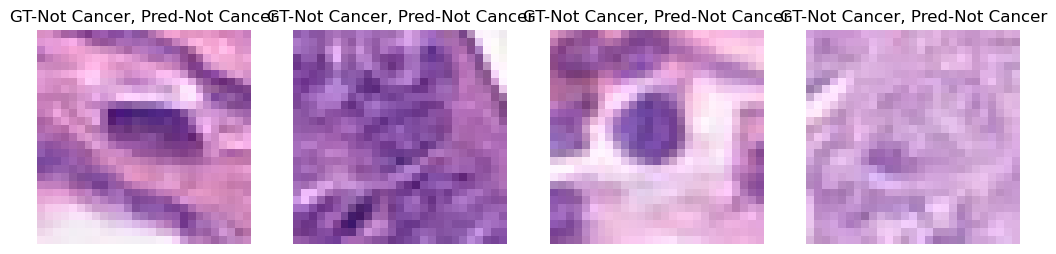

In [87]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = isCancerModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [88]:
train_data['cellType'] = train_data['cellType'].astype('int')
val_data['cellType'] = val_data['cellType'].astype('int')
test_data['cellType'] = test_data['cellType'].astype('int')

In [89]:
train_data['isCancerous'] = train_data['isCancerous'].astype('int')
val_data['isCancerous'] = val_data['isCancerous'].astype('int')
test_data['isCancerous'] = test_data['isCancerous'].astype('int')

In [90]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col=["cellType", "isCancerous"],
        target_size=(27, 27),
        batch_size=32,
        class_mode='multi_output')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col=["cellType", "isCancerous"],
        target_size=(27, 27),
        batch_size=32,
        class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col=["cellType", "isCancerous"],
        target_size=(27, 27),
        batch_size=32,
        class_mode='multi_output')

Found 7422 validated image filenames.
Found 2474 validated image filenames.
Found 1980 validated image filenames.


In [91]:
x, y = next(train_generator)
print(x.shape)
print(y[0].shape)
print(y[1].shape)

(32, 27, 27, 3)
(32,)
(32,)


In [92]:
x, y = next(train_generator)
print(np.unique(y[0]))
print(np.unique(y[1]))

[0 1 2 3]
[0 1]


In [93]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

inputs = Input(shape=(27, 27, 3))

#VGG block 1
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#VGG block 2
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

#VGG block 3
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(.2)(x)

# Two output layers
cellType_output = tf.keras.layers.Dense(CELL_TYPE_CLASSES, name = 'cellType')(x)

isCancerous_output = tf.keras.layers.Dense(256, activation='relu')(cellType_output)
isCancerous_output = tf.keras.layers.Dropout(.2)(isCancerous_output)
isCancerous_output = tf.keras.layers.Dense(1, activation='sigmoid', name = 'isCancerous')(isCancerous_output)

model_VGG_2 = Model(inputs=inputs, outputs=[cellType_output,isCancerous_output])

model_VGG_2.compile(optimizer='adam',
              loss={'cellType':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    'isCancerous' : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
              metrics={'cellType':'sparse_categorical_accuracy', 'isCancerous':'accuracy'})

In [94]:
#history_VGG_2 = model_VGG_2.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)

In [95]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(y=history_VGG_2.history['cellType_sparse_categorical_accuracy'], name='Train'))
fig.add_trace(go.Scatter(y=history_VGG_2.history['val_cellType_sparse_categorical_accuracy'], name='Valid'))
fig.update_layout(height=500, width=700,title='Accuracy for cellType feature', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [96]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(y=history_VGG_2.history['isCancerous_accuracy'],name='Train'))
fig.add_trace(go.Scatter(y=history_VGG_2.history['val_isCancerous_accuracy'],name='Valid'))
fig.update_layout(height=500, width=700, title='Accuracy for isCancerous feature', xaxis_title='Epoch',yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [97]:

eval_results = model_VGG_2.evaluate(test_generator)

# Print the validation loss and accuracy for each output
print("Loss: ", eval_results[0])
print("Cell Type Loss: ", eval_results[1])
print("Is Cancerous Loss: ", eval_results[2])
print("Cell Type Accuracy: ", eval_results[3])
print("Is Cancerous Accuracy: ", eval_results[4])

2023-05-10 18:53:35.606877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 1s 8ms/step - loss: 2.4370 - cellType_loss: 1.3863 - isCancerous_loss: 0.6929 - cellType_sparse_categorical_accuracy: 0.1525 - isCancerous_accuracy: 0.6005
Loss:  2.4369869232177734
Cell Type Loss:  1.38629949092865
Is Cancerous Loss:  0.6929463744163513
Cell Type Accuracy:  0.15252524614334106
Is Cancerous Accuracy:  0.6005050539970398


1/1 [==============================] - 0s 15ms/step


'd_inv = {v: k for k, v in label_names.items()}\nplt.figure(figsize=(16,4))\nbatches = 0\nfor x,y in test_generator:\n        batches = batches + 1\n        y_hat = cellTypeModel.predict(x, verbose=0)\n        x = np.squeeze(x)\n        if batches < 5:\n            plt.subplot(1,5,batches)\n            plt.imshow(x)\n            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))\n            \n        else:\n            break\n        \n        plt.axis(\'off\')'

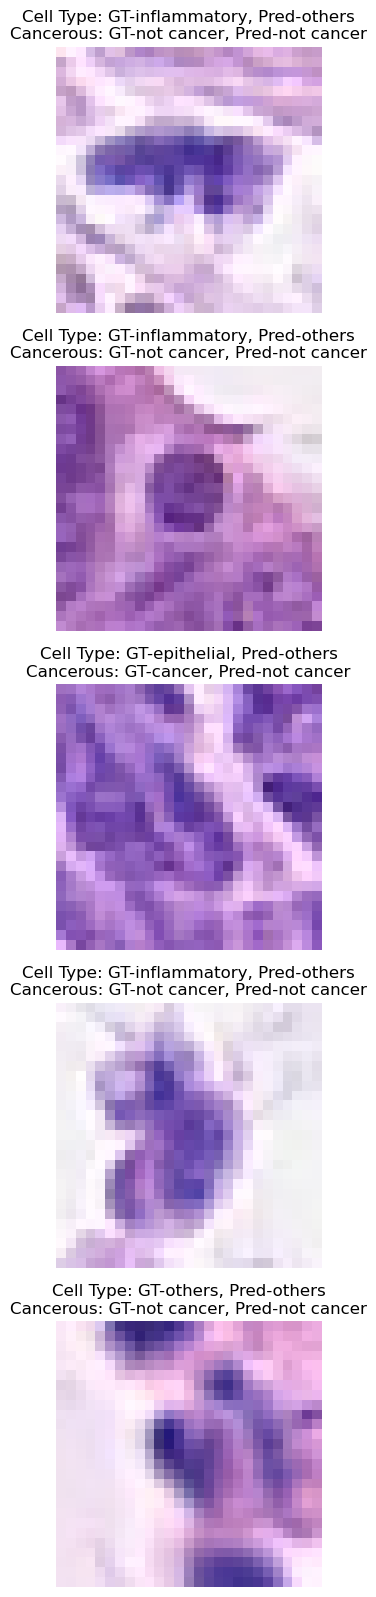

In [98]:
label_names = {'fibroplast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
lTry = {"0": 'fibroplast', "1": 'inflammatory', "2": 'epithelial', "3": 'others'}
cncNames = {0: 'no cancer', 1: 'cancer'}
def visualize_results(model, test_data, label_names, num_images=5):

    # Create a dictionary to map integer encodings back to label names
    label_names_inv = {v: k for k, v in label_names.items()}
    
    # Create a figure to display the images
    plt.figure(figsize=(4, 4 * num_images))
    
    # Iterate over the batches in the test data
    for i, (x, y) in enumerate(test_data):
        # Make predictions on the batch
        y_hat = model.predict(x)
        # Extract the cancerous GT value
        cancerous_gt = y[1][0]
        #print(cancerous_gt)
        #print(y)
        # Plot the first image in the batch
        #print(y_hat)
        if i < num_images:
            plt.subplot(num_images, 1, i + 1)
            plt.imshow(x[0])
            OMG = 'not cancer'
            if y_hat[1][0][0] > 0.5:
                OMG = 'cancer'
            if cancerous_gt == 1:
                cancerous_gt = 'cancer'
            else:
                cancerous_gt = 'not cancer'
            
            plt.title("Cell Type: GT-{}, Pred-{}\nCancerous: GT-{}, Pred-{}".format(
                lTry[str(y[0][0])], label_names_inv[np.argmax(y_hat[0][0])],
                cancerous_gt, OMG
            ))
            plt.axis('off')
        else:
            break


visualize_results(model_VGG_2, test_generator, label_names)

"""d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = cellTypeModel.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')"""

In [99]:
le.head()
train_dataE, test_dataE = train_test_split(le, test_size=0.2, random_state=42)
train_dataE, val_dataE = train_test_split(le, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 7422, Val Data: 2474, Test Data: 1980


In [100]:
batch_size = 32
train_dataE['isCancerous'] = train_dataE['isCancerous'].astype('str')
val_dataE['isCancerous'] = val_dataE['isCancerous'].astype('str')
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_dataE,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_dataE,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')




Found 7788 validated image filenames belonging to 2 classes.
Found 2596 validated image filenames belonging to 2 classes.


In [101]:
#might have to use the following lines at somepoint, IDK tho
#"""
# Freeze only the cellType_output layer
"""model_VGG_2.get_layer('cellType').trainable = False

# Recompile the model after freezing the layer
model_VGG_2.compile(optimizer='adam',
              loss={'isCancerous' : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
              metrics={'isCancerous':'accuracy'})
#"""

"model_VGG_2.get_layer('cellType').trainable = False\n\n# Recompile the model after freezing the layer\nmodel_VGG_2.compile(optimizer='adam',\n              loss={'isCancerous' : tf.keras.losses.BinaryCrossentropy(from_logits=False)},\n              metrics={'isCancerous':'accuracy'})\n#"

In [102]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)

2023-05-10 18:53:37.357547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-10 18:53:42.631642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [103]:
"""model_VGG_2.get_layer('cellType').trainable = True

# Recompile the model after freezing the layer
model_VGG_2.compile(optimizer='adam',
              loss={'cellType':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    'isCancerous' : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
              metrics={'cellType':'sparse_categorical_accuracy', 'isCancerous':'accuracy'})
#"""
eval_results = model_VGG_2.evaluate(test_generator)

# Print the validation loss and accuracy for each output
print("Loss: ", eval_results[0])
print("Cell Type Loss: ", eval_results[1])
print("Is Cancerous Loss: ", eval_results[2])
print("Cell Type Accuracy: ", eval_results[3])
print("Is Cancerous Accuracy: ", eval_results[4])


23/62 [==========>...................] - ETA: 0s - loss: 13.3911 - cellType_loss: 11.6474 - isCancerous_loss: 1.6275 - cellType_sparse_categorical_accuracy: 0.1889 - isCancerous_accuracy: 0.7812

2023-05-10 18:56:10.847134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 0s 7ms/step - loss: 13.3319 - cellType_loss: 11.5556 - isCancerous_loss: 1.6601 - cellType_sparse_categorical_accuracy: 0.1955 - isCancerous_accuracy: 0.7707
Loss:  13.33192253112793
Cell Type Loss:  11.555571556091309
Is Cancerous Loss:  1.6601074934005737
Cell Type Accuracy:  0.19545455276966095
Is Cancerous Accuracy:  0.7707070708274841


1/1 [==============================] - 0s 15ms/step


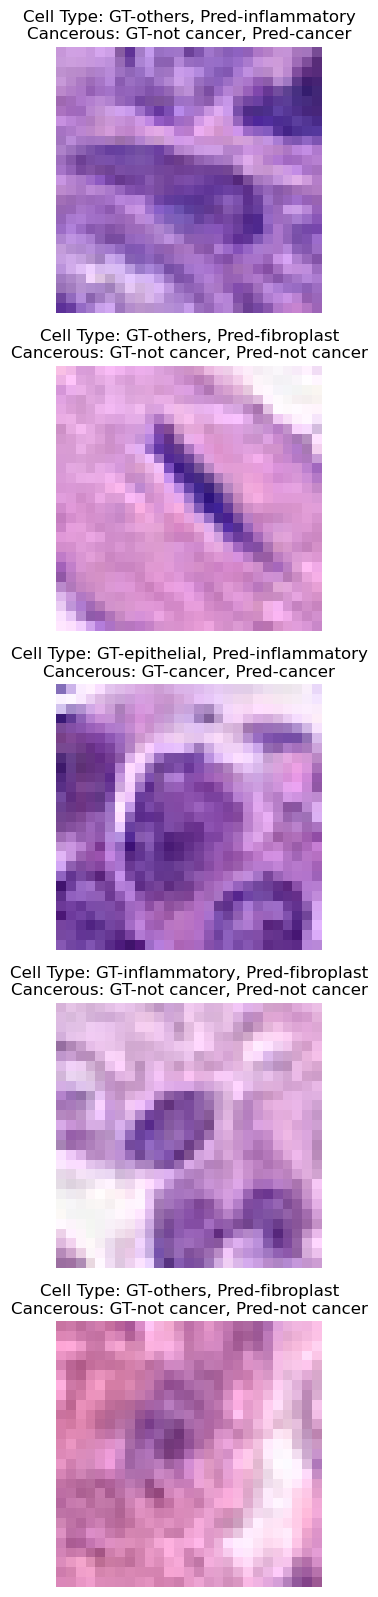

In [104]:
label_names = {'fibroplast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
lTry = {"0": 'fibroplast', "1": 'inflammatory', "2": 'epithelial', "3": 'others'}
cncNames = {0: 'no cancer', 1: 'cancer'}
def visualize_results(model, test_data, label_names, num_images=5):

    # Create a dictionary to map integer encodings back to label names
    label_names_inv = {v: k for k, v in label_names.items()}
    
    # Create a figure to display the images
    plt.figure(figsize=(4, 4 * num_images))
    
    # Iterate over the batches in the test data
    for i, (x, y) in enumerate(test_data):
        # Make predictions on the batch
        y_hat = model.predict(x)
        # Extract the cancerous GT value
        cancerous_gt = y[1][0]
        #print(y)
        # Plot the first image in the batch
       
        if i < num_images:
            plt.subplot(num_images, 1, i + 1)
            plt.imshow(x[0])
            OMG = 'not cancer'
            if y_hat[1][0][0] > 0.5:
                OMG = 'cancer'
            if cancerous_gt == 1:
                cancerous_gt = 'cancer'
            else:
                cancerous_gt = 'not cancer'
            
            plt.title("Cell Type: GT-{}, Pred-{}\nCancerous: GT-{}, Pred-{}".format(
                lTry[str(y[0][0])], label_names_inv[np.argmax(y_hat[0][0])],
                cancerous_gt, OMG
            ))
            plt.axis('off')
        else:
            break


visualize_results(model_VGG_2, test_generator, label_names)